# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [44]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [45]:
# # --------------------------
# # New packages to install if needed for mapping
# # --------------------------

# # Install plotly 
#!pip install plotly

# # Alternative is the geopandas library (which also needs descartes to work)
#!pip install git+git://github.com/geopandas/geopandas.git
#!pip install descartes

In [46]:
# --------------------------
# Load general numerical packages
# --------------------------
import numpy as np
import pandas as pd
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Load sklearn
# --------------------------
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics as metrics

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

# --------------------------
# Plotting
# --------------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

# --------------------------
# Other packages
# --------------------------
import statsmodels.api as sm
from statsmodels.api import OLS
from IPython.display import display

# --------------------------
# Mapping
# --------------------------
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

import geopandas as gpd

In [47]:
# increase display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Preparing the data: cleaning, resampling to achieve balanced classes, scaling etc
* **Part 2**: Developing maps to display the data
* **Part 3**: Exploring model performance metrics
* **Part 4**: Model tuning
* **Part 5**: Model comparisons



<div class='exercise'><b> Part 1: Preparing the data </b></div>

This notebook uses the cleaned CSV data file `data_cleaned_2016_2017.csv` downloaded from https://drive.google.com/open?id=1LCk-dDFC7O_6ek1i0IIGqE07Rq-kf1Xz. <br><br>

### Pre-processing the clean dataset

The cleaned dataset still needs some pre-processing in order to make it ready for modelling. This includes:

* Removing several more columns that are not informative, for example where they duplicate other information or only have a single value
* Drop the last digits of the zip code
* Recoding ordinal variables into numerical scales
* Recoding categorical variables into dummy variables

In [48]:
# read in the 2016-2017 data set
#original_df = pd.read_csv('../../../data/data_cleaned_2016_2017.csv', low_memory = False)
original_df = pd.read_csv('/Users/oeyvind/Documents/Studier/CS109A/Project/LendingClubFiles/data_cleaned_2016_2017id.csv', low_memory = False)

In [49]:
# --------------------------
# Function to finalise data preparation
# --------------------------
def data_prep(df):
    '''Returns a cleaned up dataframe as basis for the EDA analysis
    Input:
        df: the pd.DataFrame object
    Returns:
        clean_df: pd.DataFrame object
    '''
    clean_df = df.copy()
    
    # --------------------------
    # Definitions
    # --------------------------
    cols_to_remove = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                      'mo_sin_rcnt_tl', 'funded_amnt', 'funded_amnt_inv', 'num_sats', 
                   'application_type', 'num_actv_rev_tl', 'pymnt_plan']
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
    prefixes = ['home', 'verify', 'purp', 'state']
    
    # --------------------------
    # Drop additional uninformative columns
    # --------------------------
    clean_df = clean_df.drop(columns=cols_to_remove)
    
    # --------------------------
    # Strip xx from zip code
    # --------------------------
    clean_df["zip_code"] = [x.strip("xx") for x in clean_df["zip_code"].astype(str)]
    zip_code3 = (clean_df["zip_code"].copy()).values
    clean_df["zip_code"] = clean_df["zip_code"].astype(int)
    
    # --------------------------
    # Exclude zip code from set of predictors for analysis
    # --------------------------
    # to be added back in later for checking discrimination...
    clean_df = clean_df.drop(columns='zip_code')

    # --------------------------
    # Ordinal columns are encoded as numerical values
    # --------------------------
    clean_df["grade"].replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}, inplace = True)
    clean_df["sub_grade"].replace({"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
                                "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
                                "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
                                "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
                                "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
                                "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
                                "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}, inplace = True)

    # --------------------------
    # Nominal columns are encoded via hot encoding by adding more columns
    # --------------------------
    clean_df = pd.get_dummies(clean_df, columns=nominal_columns, prefix=prefixes, drop_first=True)

    return clean_df

In [50]:
df_all = data_prep(original_df)

In [51]:
df_all.shape

(334109, 141)

### Adjusting highly skewed variables

As we can see, annual income and dti are very skewed. Since these are both likely to be important variables, we will clip the top values before scaling. Clipping limits the values in an array to the maximum value specified. 

As can be seen in the graphs below, the values are much less skewed after clipping.

In [52]:
df = df_all.sample(n=5000)

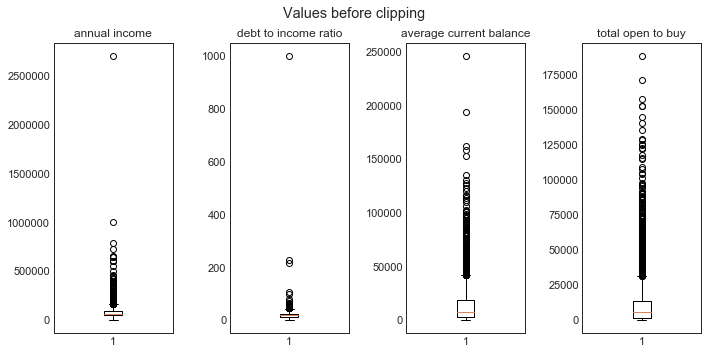

In [53]:
# Look at the distribution of some skewed variables
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 5))
ax1.boxplot(df["annual_inc"])
ax1.set_title("annual income")
ax2.boxplot(df["dti"])
ax2.set_title("debt to income ratio")
ax3.boxplot(df["avg_cur_bal"])
ax3.set_title("average current balance")
ax4.boxplot(df["bc_open_to_buy"])
ax4.set_title("total open to buy")
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Values before clipping");

In [54]:
# Clip the highest values to ensure that the variables are on a reaonable scale
df_all["annual_inc"] = np.clip(df_all["annual_inc"], a_min = None, a_max = 200000)
df_all["dti"] = np.clip(df_all["dti"], a_min = None, a_max = 40)
df_all["avg_cur_bal"] = np.clip(df_all["avg_cur_bal"], a_min = None, a_max = 30000)
df_all["bc_open_to_buy"] = np.clip(df_all["bc_open_to_buy"], a_min = None, a_max = 50000)
df = df_all.sample(n=5000)

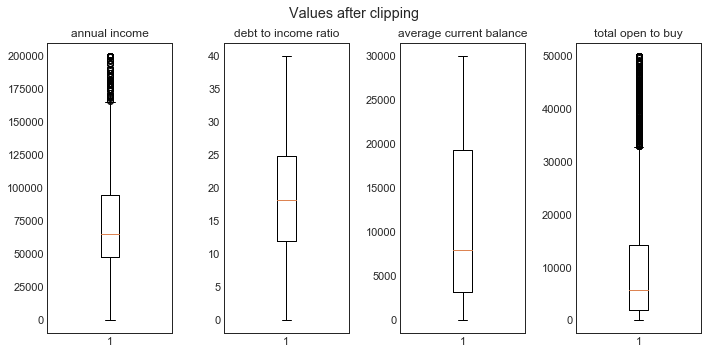

In [55]:
# Look at the distribution again
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 5))
ax1.boxplot(df["annual_inc"])
ax1.set_title("annual income")
ax2.boxplot(df["dti"])
ax2.set_title("debt to income ratio")
ax3.boxplot(df["avg_cur_bal"])
ax3.set_title("average current balance")
ax4.boxplot(df["bc_open_to_buy"])
ax4.set_title("total open to buy")
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Values after clipping");

### Generate train/test splits
The data is plit into training and test sets, stratified by loan status so that the charged off loans are represented in both sets.

In [56]:
# Function to generate train test splits
random_state = 1
def get_train_test(df, test_size = 0.2, random_state = random_state):
    result = df.copy() 
    # --------------------------
    # Train test split
    # --------------------------
    data_train, data_test = train_test_split(result, 
                                             test_size = test_size, 
                                             random_state = random_state,
                                            stratify = result.loan_status)
    
    return data_train, data_test

In [57]:
data_train, data_test = get_train_test(df_all)

### Resample to achieve balanced classes in the training set

Since we have imbalanced classes that can cause misleading assessment of model performance, we resample the classes here to achieve balanced classes in the training set (the test set is not rebalanced).

A number of techniques are available for rebalancing, including undersampling, oversampling, and SMOTE. We selected **Undersampling** of the majority class for our problem because the dataset is already large. The main disadvantage of undersampling is that it discards potentially useful data, but as noted the dataset is large enough that this should not be a significant issue.

For the initial stages, we also took the opportunity to reduce the dataset size in the initial stages, so that different model specifications could be tested faster. 

In [58]:
# Check balance of target values in the training set - it is unbalanced
data_train["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,204093
Charged Off,63194


In [59]:
# --------------------------
# Function to downsample and create balanced classes for training data and split out into x and y
# --------------------------
def balance_classes(data_train, data_test, 
                    n_samples = len(data_train[data_train["loan_status"] == "Charged Off"]), 
                    random_state = random_state):
    # --------------------------
    # Define majority and minority classes
    # --------------------------
    df_majority = data_train[data_train["loan_status"] == "Fully Paid"]
    df_minority = data_train[data_train["loan_status"] == "Charged Off"]
    
    # --------------------------
    # Downsample majority and minority classes
    # --------------------------
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,  # Downsample to match minority class 
                                     random_state = random_state) # set random seed for reproducability
    df_minority_downsampled = resample(df_minority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,  
                                     random_state = random_state) # set random seed for reproducability

    # --------------------------
    # Recombine
    # --------------------------
    df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])
    
    # --------------------------
    # Split into x and y
    # --------------------------
    X_train = df_downsampled.iloc[:, data_train.columns != 'loan_status']
    y_train = df_downsampled['loan_status']
    X_test = data_test.iloc[:, data_test.columns != 'loan_status']
    y_test = data_test['loan_status']
    
    # --------------------------
    # Recode loan status
    # --------------------------
    y_train = y_train.replace({'Fully Paid': 1, 'Charged Off': 0})
    y_test = y_test.replace({'Fully Paid': 1, 'Charged Off': 0})
    
    return X_train, y_train, X_test, y_test


In [60]:
# Create x and y data
X_train, y_train, X_test, y_test = balance_classes(data_train, data_test, 
                                                  n_samples = 5000)
# Check that training data are now balanced
y_train.value_counts().to_frame()

,loan_status
1,5000
0,5000


### Scale the data
Since we will be using models that are sensitive to scale, we need to scale the data. This is done in a function for reproducability. The unscaled features interest_rate and earliest_cr_line are extracted for use in later custom metrics.

In [61]:
def scale_data():
    nonbinary_columns = ['loan_amnt','int_rate','installment','grade','sub_grade','emp_length',
                         'annual_inc','issue_d','dti', 'delinq_2yrs','earliest_cr_line','inq_last_6mths', 
                         'open_acc','pub_rec','revol_bal','revol_util','total_acc', 'annual_inc_joint',
                         'dti_joint','acc_now_delinq','open_acc_6m','open_act_il', 'open_il_12m',
                         'open_il_24m', 'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                         'all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths',
                         'avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
                         'delinq_amnt','mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl',
                         'num_bc_sats','num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                         'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
                         'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                         'tax_liens', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_revol_util',
                         'sec_app_mths_since_last_major_derog']
    
    data_train = X_train.copy()
    data_test = X_test.copy()
    
    # --------------------------
    # Extract unscaled variables for use later
    # --------------------------
    interest_rates = (X_test["int_rate"].copy()).values
    earliest_credit = (X_test["earliest_cr_line"].copy()).values
    
    # --------------------------
    # Scaling: Incorporate here so that we can use it consistently across all models
    # --------------------------
    scaler = StandardScaler()
    data_train[nonbinary_columns] = scaler.fit_transform(data_train[nonbinary_columns])
    data_test[nonbinary_columns] = scaler.transform(data_test[nonbinary_columns])
    
    return data_train, data_test, interest_rates, earliest_credit

In [62]:
X_train, X_test, interest_rates, earliest_credit = scale_data()

<div class='exercise'><b> Part 2: Mapping </b></div>

### Using maps to display the data

This may come in useful later on when presenting the results, or as part of the EDA. The maps show that there is variation of the charge-off rate across the different States, with higher rates tending to be in the Eastern States. 

Resources used:
* Some example code on how to use Geopandas http://darribas.org/gds15/content/labs/lab_03.html 
* Downloadable shape files for the US: https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip


In [63]:
# --------------------------
# Set up data to be mapped
# --------------------------
# Recode loan status
original_df["loan_status"] = original_df["loan_status"].replace({'Fully Paid': 1, 'Charged Off': 0})

# Aggregating data by State
default_rate = 1 - original_df.groupby(["addr_state"]).mean()["loan_status"]

### Plotly: interactive map

This code generates an interactive map of charge-off rates by State.

In [64]:
# --------------------------
# Set up inputs for the map using plotly
# --------------------------
data = [ dict(
        type = 'choropleth',
        locations = default_rate.index,
        z = default_rate, 
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Default rate")
        ) ]

layout = dict(
        title = 'Average Charge off rate by State',
        geo = dict(
            scope = 'usa',
            projection = dict(type = 'albers usa' ),
            showlakes = True, 
            lakecolor = 'rgb(255, 255, 255)'),)
    

In [65]:
# --------------------------
# Create map using plotly
# --------------------------
fig = dict(data = data, 
           layout = layout)
iplot(fig, filename = 'cloropleth-map')

### Static maps using shape files

This part uses the shape files from the US census website

In [66]:
# --------------------------
# Create map using shape files 
# --------------------------

# Read in the shape files with geopandas
path = "../../shape_files/cb_2017_us_state_500k.shp" # census files
#path = "../../shape_files/states.shp"
states_map = gpd.read_file(path)

# Remove any states that aren't in the LendingClub data
states_map2 = states_map[states_map["STUSPS"].isin(list(original_df["addr_state"]))]

# Join the map data with the default rate
mapping_data = states_map2.join(default_rate, on = "STUSPS")
#mapping_data.head()

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shel

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentExcept

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shel

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not

ValueError: Null geometry has no type

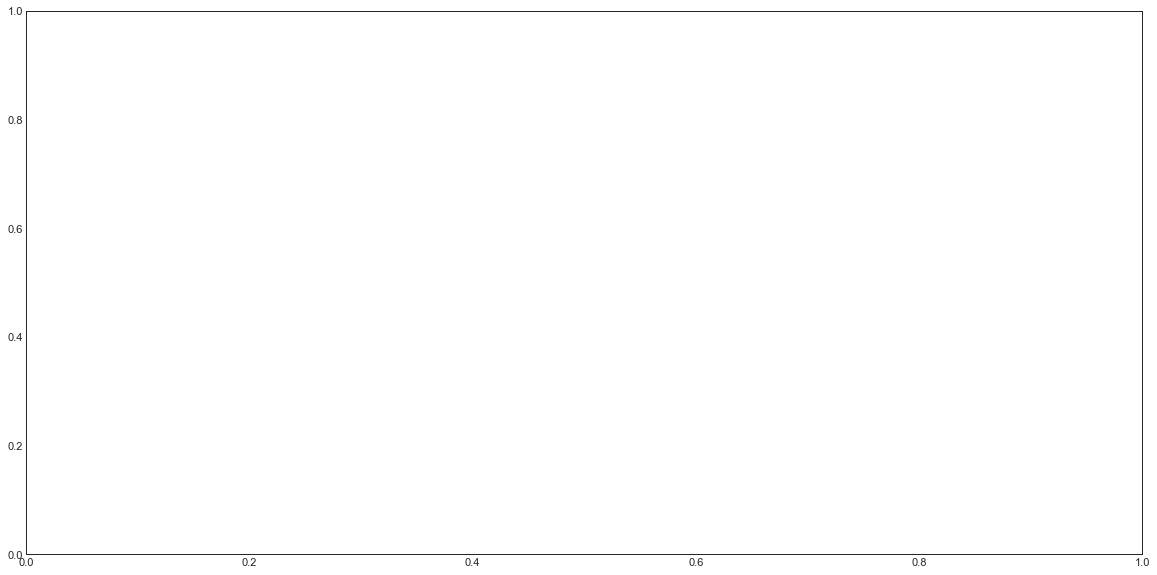

In [67]:
# Plot 
fig, ax = plt.subplots(1, figsize = (20, 10))
ax = mapping_data[mapping_data['NAME'].isin(['Alaska','Hawaii']) == False].plot(axes = ax, 
                       column = "loan_status",
                       cmap = "Blues", legend = True)

ax.axis('off')
#fig.tight_layout()
ax.set_title('Average charge off rate per State', fontdict = {'fontsize': '20', 'fontweight' : '3'});

<div class='exercise'><b> Part 3: Model performance metrics </b></div>

In this section, we explore several performance metrics to be used in our project. We also develop a wrapper function that will allow for multiple models to be trained and tested according to different performance metrics

### Overview of performance metrics used for tuning hyperparameters

Since the cost of a false positive is relatively high, this needs to be accounted for when choosing the best model, while still aiming for a good overall performance. For the purposes of this project, we consider several metrics:

* __Precision__ = True positive / (True positive + False positive). Precision represents how precise the model is in predicting positive values, and is a good metric to use when the cost of false positives is high, as in our case. 
* __Recall__ = True positive / (True positive + False negative). Recall represents how many of the actual positives were correctly picked up by the model. It is important to use when the cost of false negatives is high. 
* __F1 score__ = harmonic mean of precision and recall. There is typically a trade-off between precision and recall and F1 therefore seeks to create a balance between these two metrics. 
* __ROC__ = The ROC plots the true positive rate (sensitivity) against the false positive rate (1-specificity) and therefore shows the trade-offs between the two.
* __AUC__ = Area under the ROC curve. The AUC for a classifier with no power (random guessing) is 0.5. If the AUC is 0.7, it means there is 70% chance that model will be able to distinguish between positive class and negative class.

For tuning the hyperparameters, the primary metric we used for refitting was AUC. However, other metrics were also used to check overall performance in the visual analysis using graphs.  

The section below shows a subset of the models and performance metric graphs that were investigated in the project. 

In [68]:
# --------------------------
# Define scores to use
# --------------------------
scoring = {
    "AUC": "roc_auc", # Area under the curve
    "precision_score": make_scorer(precision_score),
    "recall_score": make_scorer(recall_score),
    "accuracy_score": make_scorer(accuracy_score),
    "f1_score": make_scorer(f1_score)
}

### Developing a wrapper function to optimise model hyper parameters according to a specified metric

When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. 

Setting refit_score = 'AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score. Other metrics could also be used. 

In [69]:
# --------------------------
# Function that use GridSearchCV to find the model with the best parameters 
# According to the specified "refit score"
# --------------------------
def grid_search_wrapper(clf, param_grid, refit_score = "AUC"):  
    '''
    Finds the optimal model according to "refit score" using GridSearchCV
    Prints model performance metrics
    Input:
        clf: the classification model
        param_grid: grid of parameters to search over
        refit_score: AUC or precision_score
    Returns:
        grid_search: fitted model object
    '''
    # --------------------------
    # Fit the classifier model
    # --------------------------
    grid_search = GridSearchCV(clf, 
                               param_grid, 
                               scoring = scoring, 
                               refit = refit_score,
                               cv = 5, 
                               return_train_score = True, 
                               n_jobs = -1 # Parallel processing
                              )  
    grid_search.fit(X_train.values, y_train.values)
    best_model = grid_search.best_estimator_
    all_scores = grid_search.cv_results_

    # --------------------------
    # Review parameters and performance for best model
    # --------------------------
    y_test_pred = grid_search.predict(X_test.values)
    y_test_pred_prob = grid_search.predict_proba(X_test)[:,1]
    print("Best params for {}".format(refit_score))
    print(grid_search.best_params_)
    print("Best score:", np.around(grid_search.best_score_, 2))
    print("Range", np.around(max(all_scores["mean_test_"+refit_score]), 2), np.around(min(all_scores["mean_test_"+refit_score]), 2))

    # --------------------------
    # Print confusion matrix (test data)
    # --------------------------
    print("\nConfusion matrix of model optimized for {} on the test data:".format(refit_score))
    display(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=["pred_neg", "pred_pos"], index=["neg", "pos"]))
    
    # --------------------------
    # Print classification report
    # --------------------------
    print("\nClassification report for best model:")
    print(classification_report(y_test, y_test_pred, digits = 2))

    
    return grid_search

In [70]:
# --------------------------
# Function to generate the plots
# --------------------------

def plot_scorers(model, param_to_plot):
    results = model.cv_results_ # Get the CV results to show error bars
    best_model = model.best_estimator_
    
    # --------------------------
    # Retrieve predicted probabilities for the best model &
    # Get performance for different thresholds
    # --------------------------
    y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
    F1 = 2*(p[:-1]*r[:-1]) / (p[:-1]+r[:-1])
    
    # --------------------------
    # Plots the first two scorers - AUC and precision
    # --------------------------
    gridsize = (3, 2)
    fig = plt.figure(figsize = (9, 10))
    ax0 = plt.subplot2grid(gridsize, (0, 0), colspan = 2, rowspan = 2)
    ax1 = plt.subplot2grid(gridsize, (2, 0))
    ax2 = plt.subplot2grid(gridsize, (2, 1))

    ax0.set_title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize = 16)

    ax0.set_ylim(0.6, 0.8) # Zoom in so that differences can be seen
    ax0.set_xlabel(str(param_to_plot))
    ax0.set_ylabel("Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_"+str(param_to_plot)].data, dtype = float)

    # Plot the first two scorers
    for scorer, color in zip(scoring, ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax0.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == "test" else 0, color=color)
            ax0.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax0.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax0.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    ax0.legend(loc = "best");

    # --------------------------
    # Make graphs to show ROC and Precision-recall curves
    # --------------------------

    # ROC plot
    ax1.set_title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_prob))
    ax1.plot(fpr, tpr, "b")
    ax1.plot([0,1], [0,1], "r--")
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate");

    # Precision-recall plot
    ax2.set_title("Precision and Recall Scores as a function of the decision threshold")
    ax2.plot(thresholds, p[:-1], "b--", label = "Precision")
    ax2.plot(thresholds, r[:-1], "g-", label = "Recall")
    ax2.plot(thresholds, F1, "k", label = "F1 score")
    ax2.set_ylim([0,1])
    ax2.set_ylabel("Score")
    ax2.set_xlabel("Decision Threshold")
    ax2.legend(loc = "best");
    
    fig.tight_layout()

<div class='exercise'><b> Part 4: Model tuning </b></div>

### Find the best model of each type

This section develops a process to search through a grid of tuning parameters using the wrapper functions shown above and return the best models.

In [71]:
# --------------------------
# Function to run grid search, generate graphs and return the best model
# -------------------------- 

def trial_model(model, refit_score = "AUC", param_to_plot = "Default"):
    print("--------------------------")
    print(model["name"])
    print("--------------------------")

    grid_search = grid_search_wrapper(model["clf"], model["parameter_grid"], 
                                      refit_score = refit_score)
    if param_to_plot == "Default":
        param_to_plot = list(model["parameter_grid"])[0]

    plot_scorers(model = grid_search, 
                 param_to_plot = param_to_plot)
    return grid_search.best_estimator_


In [72]:
# --------------------------
# Create dictionaries for each model 
# -------------------------- 

Logistic = {"name": "Logistic",
            "clf": LogisticRegression(penalty = "l2"),
            "parameter_grid": {"C": np.logspace(-5, 0.5, 5)}
           }
RandomForest = {"name": "RandomForest",
                "clf": RandomForestClassifier(max_depth = 15, n_estimators = 500, min_samples_split = 9, n_jobs = -1),
                "parameter_grid": {"max_features": [2, 4, 6]}
               }
AdaBoost = {"name": "Adaboost",
            "clf": AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1)),
           "parameter_grid": {"n_estimators": [25 * x for x in range(1, 5)]}}

Gradient = {"name": "Gradient",
           "clf": GradientBoostingClassifier(n_estimators = 400),
           "parameter_grid": {"max_features": [0.4, 0.5, 0.6]}}


--------------------------
Logistic
--------------------------
Best params for AUC
{'C': 1e-05}
Best score: 0.54
Range 0.54 0.54

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,0,15799
pos,0,51023



Classification report for best model:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15799
          1       0.76      1.00      0.87     51023

avg / total       0.58      0.76      0.66     66822



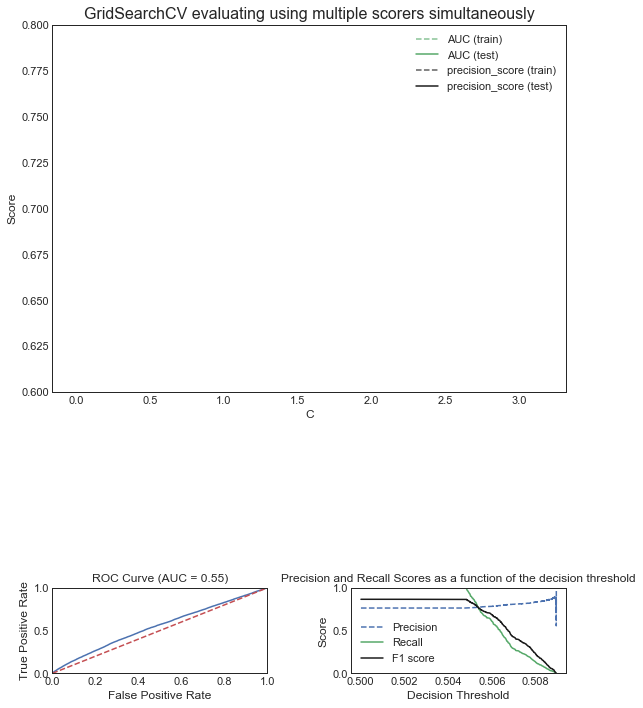

In [73]:
# --------------------------
# Search through the parameter grid and return the best model for each type
# -------------------------- 
logistic_best = trial_model(Logistic)

--------------------------
RandomForest
--------------------------
Best params for AUC
{'max_features': 6}
Best score: 0.72
Range 0.72 0.71

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,10837,4962
pos,18877,32146



Classification report for best model:
             precision    recall  f1-score   support

          0       0.36      0.69      0.48     15799
          1       0.87      0.63      0.73     51023

avg / total       0.75      0.64      0.67     66822



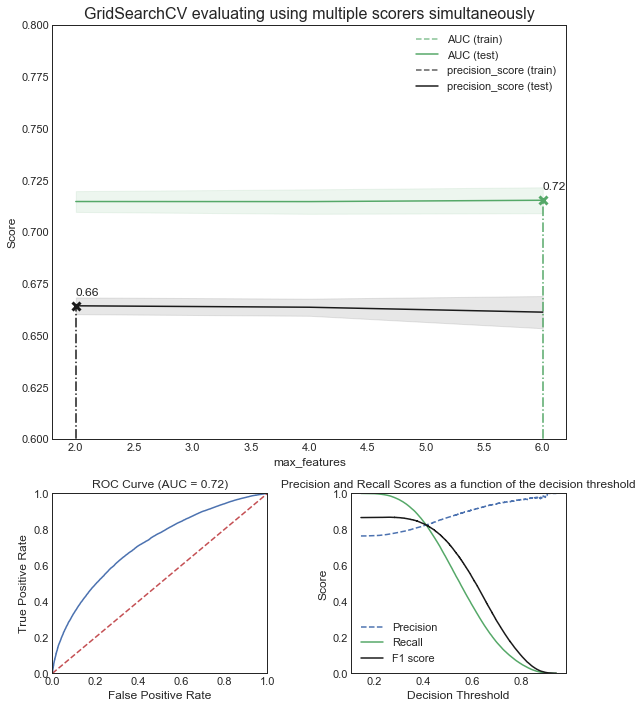

In [74]:
# RF takes a while to run, especially if the grid is large so be careful about adding too many parameters
rf_best = trial_model(RandomForest, param_to_plot = "max_features")

--------------------------
Adaboost
--------------------------
Best params for AUC
{'n_estimators': 50}
Best score: 0.71
Range 0.71 0.71

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,10511,5288
pos,18659,32364



Classification report for best model:
             precision    recall  f1-score   support

          0       0.36      0.67      0.47     15799
          1       0.86      0.63      0.73     51023

avg / total       0.74      0.64      0.67     66822



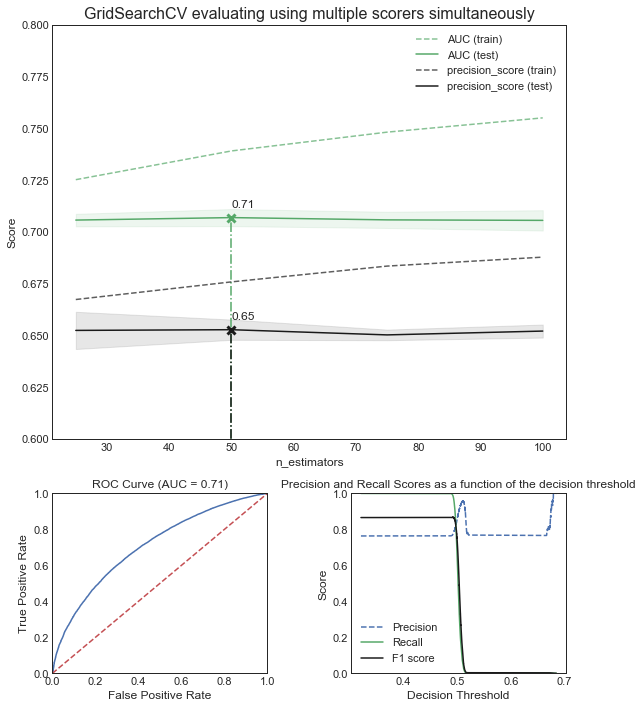

In [75]:
ada_best = trial_model(AdaBoost)

--------------------------
Gradient
--------------------------
Best params for AUC
{'max_features': 0.5}
Best score: 0.71
Range 0.71 0.71

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,10637,5162
pos,18252,32771



Classification report for best model:
             precision    recall  f1-score   support

          0       0.37      0.67      0.48     15799
          1       0.86      0.64      0.74     51023

avg / total       0.75      0.65      0.68     66822



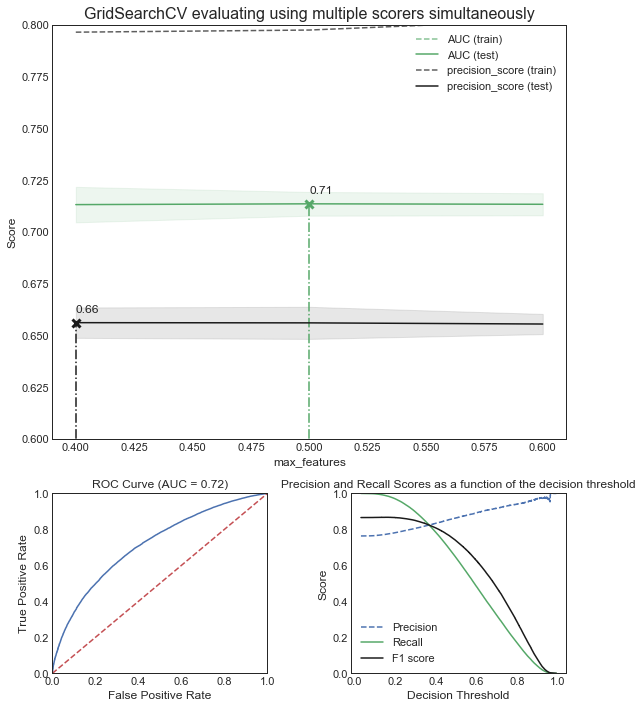

In [77]:
grad_best = trial_model(Gradient)

<div class='exercise'><b> Part 5: Model comparisons </b></div>

This section develops a function to compare the performance metrics for all of the best models found in part 4

In [80]:
# --------------------------
# List of best models from the previous tuning step
# -------------------------- 
model_dict = {"Logistic": logistic_best,
              "Random Forest": rf_best,
              "Adaboost": ada_best,
              "Gradient": grad_best
            }

In [81]:
# --------------------------
# Function to generate comparisons of the best models of each type
# -------------------------- 
def compare_models(model_dict): 

    cols = ["model", "roc_auc_score", "accuracy_score", "precision_score", "recall_score", "f1_score"]
    models_report = pd.DataFrame(columns = cols)
    
    plt.figure(figsize = (6, 6))

    for clf, clf_name in zip(model_dict.values(), model_dict.keys()):
        # --------------------------
        # Create a dataframe with the performance metrics
        # -------------------------- 
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test.values)
        y_test_pred_prob = clf.predict_proba(X_test.values)[:,1]
        
        report = pd.Series({"model": clf_name,
                         "roc_auc_score" : roc_auc_score(y_test, y_test_pred_prob),
                         "accuracy_score": accuracy_score(y_test, y_test_pred),
                         "precision_score": precision_score(y_test, y_test_pred),
                         "recall_score": recall_score(y_test, y_test_pred),
                         "f1_score": f1_score(y_test, y_test_pred)})
        
        models_report = models_report.append(report, ignore_index = True)
        
        # --------------------------
        # Generate all the ROC curves on the same plot
        # -------------------------- 
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob, drop_intermediate = False, pos_label = 1)
        
        # Plot 
        plt.plot(fpr, tpr, label = clf_name, alpha = 0.8)
    plt.title("ROC Curves")
    plt.legend(loc = 2)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.plot([0,1], [0,1], "r--")
    plt.title("ROC Curves")
    plt.show();
    
    return models_report


### Comparison of the best models

As can be seen from below, the different classifiers do not perform that differently (at least for the parameters tried so far). 

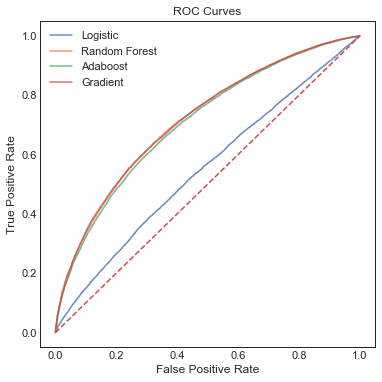

,model,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
0,Logistic,0.549464,0.763566,0.763566,1.000000,0.865934
1,Random Forest,0.715631,0.642274,0.865811,0.628991,0.728641
2,Adaboost,0.707207,0.641630,0.859556,0.634302,0.729946
3,Gradient,0.715921,0.650205,0.862610,0.644552,0.737807


In [82]:
# Run the function above to compare all of the best models
models_report = compare_models(model_dict = model_dict)
models_report

### Factors that drive the investment strategy

A comparison of the feature importance for the random forest and gradient boosting shows that they are selecting similar features in the top 10, although with slightly different weights/ordering.  

The underlying characteristics that drive the investment strategy are therefore shown below for the random forest, and for comparison for the gradient boosting. 

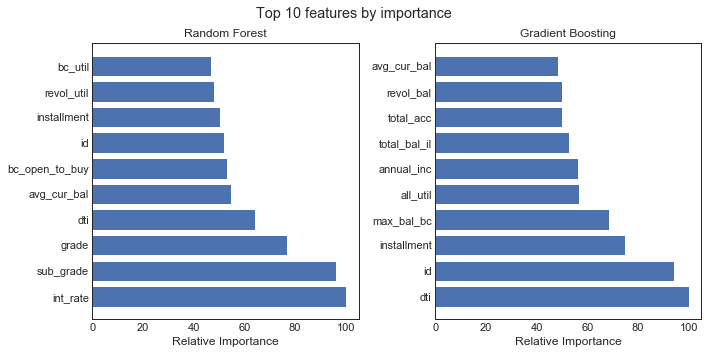

In [83]:
def feature_importance_plot(model, title, ax, num_to_plot = 10):
    # Find feature importance
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(-feature_importance)[0: num_to_plot]
    pos = np.arange(sorted_idx.shape[0]) + .5

    # Plot
    ax.barh(pos, feature_importance[sorted_idx], align = "center")
    ax.set_yticks(pos)
    ax.set_yticklabels(X_test.columns[sorted_idx])
    ax.set_xlabel("Relative Importance")
    ax.set_title(title)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

feature_importance_plot(model_dict["Random Forest"], "Random Forest", ax = ax1)
feature_importance_plot(model_dict["Gradient"], "Gradient Boosting", ax = ax2)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Top 10 features by importance");


<div class='exercise'><b> Part 6: Tuning the preferred model and exploring further metrics </b></div>

### Model selection

All of the models explored above perform fairly similarly in terms of the metrics, and there is not much to choose between them. For the purposes of exploring further model performance metrics beyond the standard ones, we have picked one model to take forward: random forest. The same approach could equally be applied to any of the other models. 


In [84]:
# --------------------------
# Define the best model to use in this section
# --------------------------
best_model = rf_best

# --------------------------
# Retrieve predicted probabilities for the best model 
# --------------------------
y_test_pred_prob = best_model.predict_proba(X_test.values)[:,1] # Predicted probabilities on the test set
y_test_pred = best_model.predict(X_test.values)

### Adjusting thresholds
One way to do the final tuning is to adjust the decision thresholds.  

The code below shows how we can maximises the precision metric, but this results in very few positive predictions overall (i.e. true positives are reduced as well as false positives). 

This might be suitable for a very conservative investor, but it also severely limits the total number of loans that would be selected for investment.

In [85]:
# --------------------------
# Get performance for different thresholds
# --------------------------
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
F1 = 2*((p*r)/(p+r))

best_threshold_index = np.argmax(p) 
best_threshold_precision = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]

print("Threshold that maximises precision is:")
print(best_threshold_precision)


Threshold that maximises precision is:
0.9118375305952445


In [86]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


In [87]:
# Calculate new predicted values using the threshold that maximises precision
y_max_precision = adjusted_classes(y_test_pred_prob, 
                              t = best_threshold_precision)

print(pd.DataFrame(confusion_matrix(y_test, y_max_precision),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

     pred_neg  pred_pos
neg     15799         0
pos     50955        68


<font color = "red">

### Expected returns - Oyvind to complete

Explanations needed

Also discussed:
* Choose 1000 loans for each strategy?


In [211]:
# Choose the index of 1000 loans according to those predicted to have the best chance of being paid off
best_1000 = np.argsort(-y_test_pred_prob)[0:1000] # Use negative values to get sorting from highest to lowest

#Find the id and index of the 1000 best loans, to be able to select them later
best_1000_df = X_test.iloc[best_1000]
best_1000_index = np.array(best_1000_df.index)
best_1000_id = np.array(best_1000_df['id'])

#Create a dictionary to store investment DataFrames
dict_investments = {}

# Have a look at the top 5 
y_test_pred_prob[best_1000][0:5]

array([0.94215095, 0.94083462, 0.93953449, 0.93910062, 0.93842475])

In [202]:
# --------------------------
# Import the complete set of data files
# -------------------------- 
Q1_2017 = pd.read_csv('../../../data/LoanStats_2017Q1.csv',low_memory=False,skiprows=1)
Q2_2017 = pd.read_csv('../../../data/LoanStats_2017Q2.csv',low_memory=False,skiprows=1)
Q3_2017 = pd.read_csv('../../../data/LoanStats_2017Q3.csv',low_memory=False,skiprows=1)
Q4_2017 = pd.read_csv('../../../data/LoanStats_2017Q4.csv',low_memory=False,skiprows=1)

Q1_2016 = pd.read_csv('../../../data/LoanStats_2016Q1.csv',low_memory=False,skiprows=1)
Q2_2016 = pd.read_csv('../../../data/LoanStats_2016Q2.csv',low_memory=False,skiprows=1)
Q3_2016 = pd.read_csv('../../../data/LoanStats_2016Q3.csv',low_memory=False,skiprows=1)
Q4_2016 = pd.read_csv('../../../data/LoanStats_2016Q4.csv',low_memory=False,skiprows=1)

Year_2016_2017 = pd.concat([Q1_2017,Q2_2017,Q3_2017,Q4_2017,Q1_2016,Q2_2016,Q3_2016,Q4_2016])


In [269]:
df_return = Year_2016_2017.loc[Year_2016_2017['loan_status'].isin(['Fully Paid', 'Charged Off'])]
dict_investments['df_return'] = df_return.copy()
dict_investments['df_return'] = dict_investments['df_return'].reset_index()
dict_investments['df_return'] = dict_investments['df_return'].set_index('id')
dict_investments['df_return_best_1000'] = dict_investments['df_return'].iloc[best_1000_index]

In [204]:
# Select relevant data - added recoveries (post charge-off gross recovery)
result = df_return[['loan_amnt','int_rate','loan_status','total_pymnt', 'recoveries', 'collection_recovery_fee']]

In [205]:
# --------------------------
# Make adjustments to dataframe
# -------------------------- 

result['Recieved'] = (result['total_pymnt'] + result['recoveries'] - result['collection_recovery_fee'] ) / result['loan_amnt'] *100
result['Recieved'].astype(float)
result['Gain loss'] = (result['Recieved'] - 100)
result['int_rate'] = result['int_rate'].str[:-1].astype(float)
result['int_round'] = result['int_rate'].round(0).astype(int)

In [206]:

# --------------------------
# Find the stats for the loans that gets charged off
# The investor experience an average loss of 55 % of each loan that gets charged off
# -------------------------- 
result[result['loan_status']=='Charged Off']['Gain loss'].describe()

count    78993.000000
mean       -54.885181
std         22.596597
min       -100.000000
25%        -70.693600
50%        -56.850333
75%        -41.130076
max        334.060000
Name: Gain loss, dtype: float64

In [207]:
# --------------------------
# Find the stats for the loans that gets fully paid
# The investor experience an average gain of 10,4 % of each loan that gets paid
# -------------------------- 
result[result['loan_status']=='Fully Paid']['Recieved'].describe()

count    255116.000000
mean        110.474704
std           7.124300
min         100.000000
25%         105.395432
50%         109.314933
75%         114.122336
max         163.812592
Name: Recieved, dtype: float64

In [208]:

# --------------------------
# Calculate investors return if the investor invests $100 in each of the 334109 loans
# -------------------------- 

gb = result[['int_round', 'Gain loss']].groupby(['int_round']).sum()

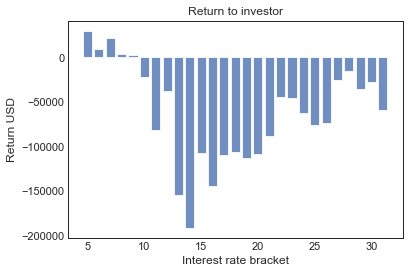

In [209]:
plt.title('Return to investor')
plt.bar(gb.index, gb['Gain loss'], align='center', alpha=0.8)
plt.ylabel('Return USD')
plt.xlabel('Interest rate bracket');

In [261]:
def calculate_cash_flow(loan_df, output_df):
    dict_investments[output_df] = dict_investments[loan_df][['term','int_rate','issue_d','last_pymnt_d','loan_status']]
    dict_investments[output_df]['Issued'] = pd.to_datetime(dict_investments[output_df]['issue_d'])
    dict_investments[output_df]['End'] = pd.to_datetime(dict_investments[output_df]['last_pymnt_d'])
    dict_investments[output_df]['months'] = dict_investments[output_df].term.str.extract('(\d+)')
    dict_investments[output_df]['interest'] = dict_investments[output_df].int_rate.str.extract('(\d*\.\d*)')
    dict_investments[output_df]['days_paid'] = dict_investments[output_df]['End'] - dict_investments[output_df]['Issued']
    dict_investments[output_df]['months'] = dict_investments[output_df]['months'].astype('int')
    dict_investments[output_df]['daily_installment'] = (100/(dict_investments[output_df]['months']*30))
    dict_investments[output_df]['interest'] = dict_investments[output_df]['interest'].astype('float')
    dict_investments[output_df]['daily_interest'] = ((dict_investments[output_df]['interest']/360))
    dict_investments[output_df] = dict_investments[output_df].drop(columns=['term','int_rate','issue_d','last_pymnt_d'])
    dict_investments[output_df]['lump'] = 100 - (dict_investments[output_df]['daily_installment'] * dict_investments[output_df]['days_paid'].dt.days)

In [270]:
calculate_cash_flow('df_return','df_simulate')
calculate_cash_flow('df_return_best_1000','df_simulate_best_1000')

In [273]:
days = pd.date_range('2016-01-01', '2018-12-31', freq='D')
months = pd.date_range('2016-01-01', '2018-12', freq=pd.offsets.MonthBegin())
dict_investments['All_loans'] = pd.DataFrame(index=days)
dict_investments['Best_1000_loans'] = pd.DataFrame(index=days)

In [278]:
# --------------------------
# Function to calculate the investments case, and draw graphs
# -------------------------- 

def investments(df, df2):
    #Calculate the investments (outlay) the investor need to put up
    dict_investments[df]['Investments'] = 0.0
    for i in months:
        dict_investments[df]['Investments'].loc[str(i)] = df2['loan_status'][df2['Issued'] == i].count() * -100
    
    #Calculate the interest the investor gains for the loans
    dict_investments[df]['Interest'] = 0.0
    for i in days:
        dict_investments[df]['Interest'].loc[str(i)] = df2['daily_interest'][(df2['Issued'] < i) & (df2['End'] > i)].sum()
        
    #Calculate the installments the investor gets returned
    dict_investments[df]['Installments'] = 0.0
    for i in days:
        dict_investments[df]['Installments'].loc[str(i)] = df2['daily_installment'][(df2['Issued'] < i) & (df2['End'] > i)].sum() 
        
    #Calculate the lump sums the investor gets when someone pays back their loan before schedule
    dict_investments[df]['Lump'] = 0.0
    for i in days:
        dict_investments[df]['Lump'].loc[str(i)] = df2['lump'][(df2['End'] == i) & (df2['loan_status'] == 'Fully Paid')].sum()
    
    dict_investments[df]['Daily net'] = 0
    dict_investments[df]['Total'] = 0
    dict_investments[df]['Daily net'] = dict_investments[df].sum(axis=1)
    dict_investments[df]['Total'] = dict_investments[df]['Daily net'].cumsum()
    
    #Draw up graph
    plt.figure(figsize=(20,10))
    plt.title('Investor net gain / loss',size=25)
    plt.plot(dict_investments[df]['Total'])
    plt.ylabel("US Dollar", size=15)

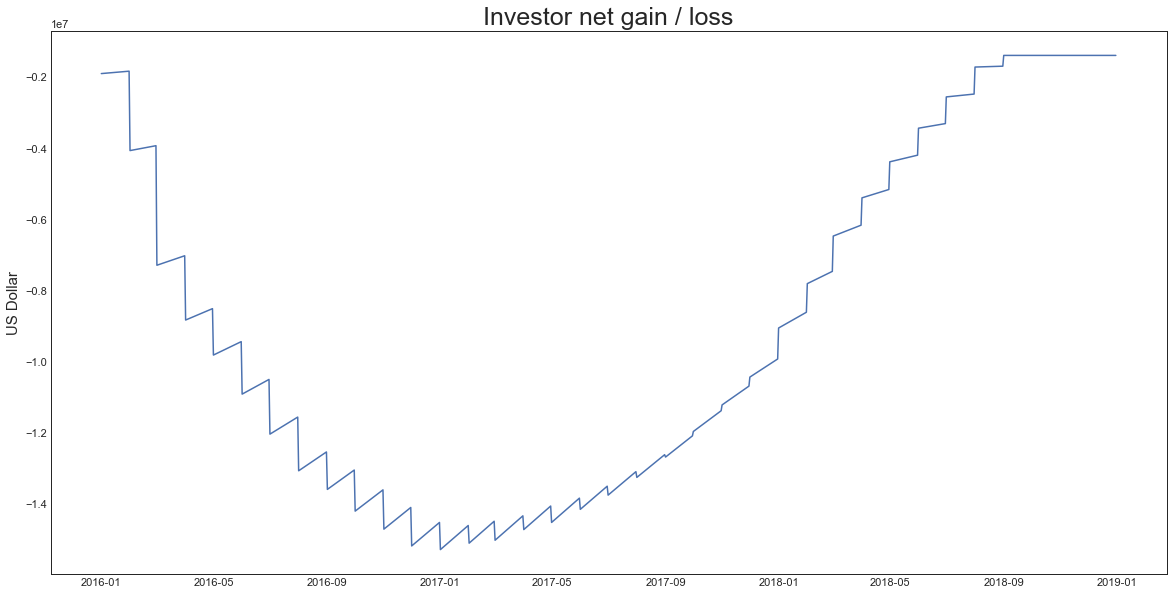

In [275]:
investments('All_loans', dict_investments['df_simulate'])

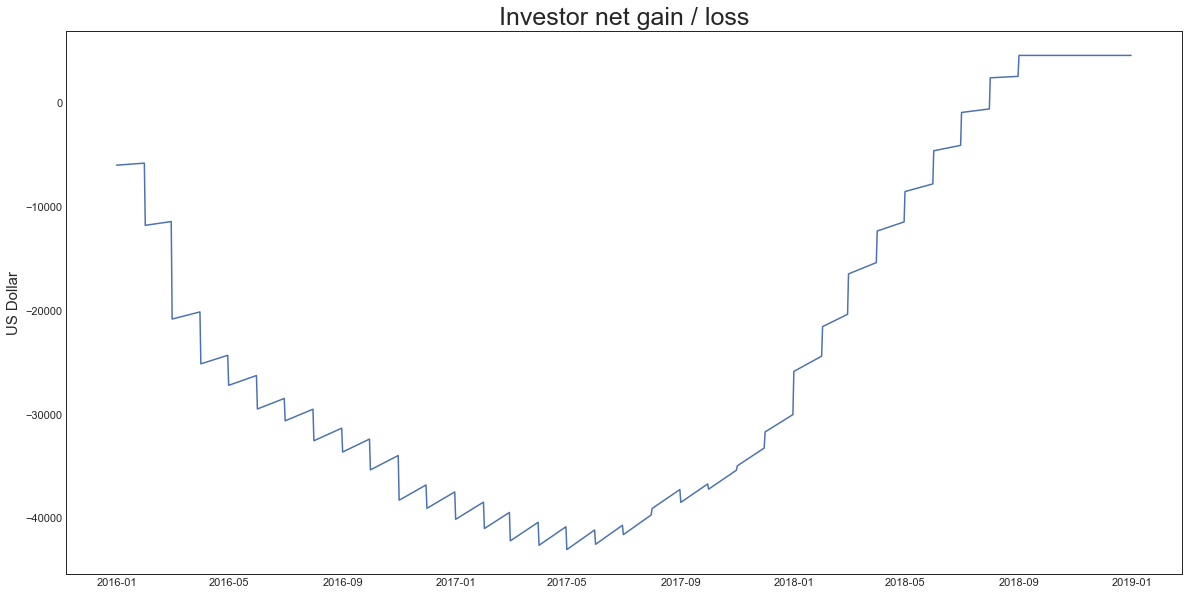

In [279]:
investments('Best_1000_loans', dict_investments['df_simulate_best_1000'])

In [323]:
print("An investor that invest 100 USD in every loan will need to invest {}.".format(round(dict_investments['All_loans']['Total'].min(),0)))
print("That investor will end up with {} the December 31th 2018.\n".format(round(dict_investments['All_loans'].loc['2018-12-31']['Total']),2))
print("An investor that invest 100 USD in the 1000 best loans according to our model will need to invest {}".format(dict_investments['Best_1000_loans']['Total'].min()))
print("That investor will end up with {} December 31th 2018.\n".format(round(dict_investments['Best_1000_loans'].loc['2018-12-31']['Total']),2))
print("However, the first investor invests 354.865 times more money than the second.\n")
print("If the second would invest the same amount in our 1000 best loans, the investor would end up with {} December 31th 2018.".format(int(dict_investments['Best_1000_loans'].loc['2018-12-31']['Total']*354.865)))

An investor that invest 100 USD in every loan will need to invest -15284048.0.
That investor will end up with -1397878.0 the December 31th 2018.

An investor that invest 100 USD in the 1000 best loans according to our model will need to invest -43070.61949999998
That investor will end up with 4586.0 December 31th 2018.

However, the first investor invests 354.865 times more money than the second.

If the second would invest the same amount in our 1000 best loans, the investor would end up with 1627486 December 31th 2018.



### Fairness metrics

We explored the possibility of implementing the IBM 360 fairness libraries in our project, as these seemed to offer the functionalities needed. Unfortunately we were unable to get the library to work without errors in the context of our project. 

Therefore, we implemented a selection of the fairness metrics directly in the function below. This calculates the following metrics for each model:

* __Equal opportunity__: the difference between the ratio of true positives to positive examples for the protected vs unprotected groups
* __Predictive equality__: the difference in accuracy of predictions for the protected vs unprotected groups
* __Statistical parity__: the difference in proportion of positive classifications in the protected vs unprotected groups


In [306]:
# --------------------------
# Create a custom scoring function that calculates fairness metrics
# -------------------------- 
def fairness_report(y_test, y_test_pred, protected_class):
    """Adapted from IBM360 Research.
        Calculates various fairness metrics:
        
        - Equal opportunity: Return the ratio of true positives to positive examples `TPR = TP/P`
        - Predictive equality: We define the predictive equality as the situation when accuracy 
        of decisions is equal across race groups, as measured by false positive rate (FPR). 
        - Statistical parity: Statistical parity denotes an equal proportion of each protected category in question are positively classified
        
        Returns: Metric differences between priviliged and unpriviliged groups:
        Equal opportunity, Predictive equality, Statistical parity
    """
    results = {}
    
    # Recoded to work with series
    protected = np.where(protected_class == 1) # Select protected class
    not_protected = np.where(protected_class == 0) # Select unprotected class
    
    # --------------------------
    # Calculate metrics for protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[protected], y_test_pred[protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP
    
    TPR_protected = TP / P
    FPR_protected = FP / N
    Parity_protected = (TP + FP) / len(y_test.values[protected])
    
    # --------------------------
    # Same for un-protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[not_protected], y_test_pred[not_protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP    
    
    TPR = TP / P
    FPR = FP / N
    Parity = (TP + FP) / len(y_test.values[not_protected])
    
    results = {"equal_opportunity": np.round(TPR_protected - TPR, 3),
               "predictive_equality": np.round(FPR_protected - FPR, 3),
               "statistical_parity": np.round(Parity_protected - Parity, 3)
        
    }
    
    return pd.Series(results)
    

### Explore fairness: age

We assume that the earliest credit line is a good proxy for age. If we assume that people get their first line of credit at about 18 years old, the distribution of age in our dataset is shown below.

The results show that the model slightly favours older loan applicants (it has positive values for the fairness metrics).

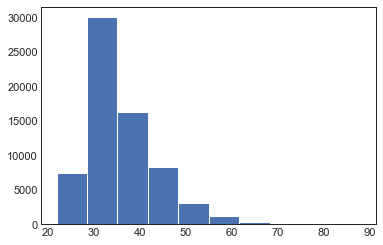

In [48]:
# Explore age distribution in the test set
Age = 2018 - np.array(earliest_credit) + 18 # Assume earliest credit was obtained at 18 years old
plt.hist(Age);

In [49]:
earliest_credit

array([2000, 2012, 2003, ..., 1993, 1987, 1993])

In [50]:
# Define over 50 as protected class
Over_50 = np.array((Age >=50)*1)

In [51]:
# Fairness for best model with no further adjustments
fairness = fairness_report(y_test, y_test_pred, 
                                  protected_class = Over_50)
fairness

equal_opportunity      0.100
predictive_equality    0.117
statistical_parity     0.108
dtype: float64

### Explore fairness: race

The Lending Club data does not contain any information in regards to race. We do therefore have to make some general assumptions, that may or may not be true.

We are using data from the US census, and have aggregated the information up to the 3 first digits of the zip-code, to be compatable with the Lending Club data. We have for each area seen if a higher propotion of the population is black compared to the propotion of the state as a whole.

In [310]:
census_ohe = pd.read_csv('../data/Census_one_hot_encoded.csv', low_memory = False)
census_ohe = census_ohe[['Zip3','Higher % blacks than state']]
census_ohe['Zip3'] = census_ohe['Zip3'].astype('str')
census_ohe['Zip3'] = census_ohe['Zip3'].str.zfill(3)
census_ohe = census_ohe.set_index('Zip3')
census_ohe = census_ohe.to_dict()

In [315]:
population = pd.concat([X_test, original_df[['zip_code']]], axis=1, join_axes=[X_test.index])
population['zip_code'] = population['zip_code'].astype(str).str.slice(0,3)
population['Higher % blacks than state'] = population['zip_code'].map(census_ohe['Higher % blacks than state'])

In [316]:
protected_class = np.array((population['Higher % blacks than state']*1))

In [317]:
# Fairness for best model with no further adjustments
fairness = fairness_report(y_test, y_test_pred, 
                                  protected_class = protected_class)
fairness

equal_opportunity     -0.012
predictive_equality   -0.027
statistical_parity    -0.018
dtype: float64

<div class='exercise'><b> Part 7: Final conclusions and recommendations for further work </b></div>

### Roland
Ideas we discussed were:
* Models could be stacked/combined to generate better overall performance, although this would reduce interpretability
* More advanced models like neural networks may reach higher performance, but again we did not explore these due to lack of interpretability
